In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import model_selection, metrics, linear_model
sns.set(rc={'figure.figsize':(10,10)})

### Algorithm

- In the forward direction: refit the model with each of the remaining predictors and incorporate the one which brings about the greatest improvement in performance.
- In the reverse direction: refit the model dropping each of the remaining predictors and remove the one which leads to the smallest reduction in performance.
- There are $1 + \frac{p(1 + p)}{2}$ combinations to consider.

In [2]:
def stepwise(X, y, forward=True):
    ''' X: n x p numpy array
        y: n x 1 numpy array''' 
    
    # How big is the search?
    p = X.shape[1]
    print('Searching over {} models'.format(int(1 + ((p * (1 + p))/2))))

    # The degenerate case
    # - all the predictors if backward stepwise
    # - none of the predictors if forward stepwise
    best = np.repeat(0, p)
    selection = best if forward else np.logical_not(best)
    Xf = X @ np.diag(selection)
    model = linear_model.LinearRegression().fit(Xf, y)
    score = model.score(X, y)

    # Add result of degenerate case to acummulators
    scores = [score]
    models = [model]
    vectors = [best]
    
    # `Best` is a binary vector
    # - forward stepwise: 1's represent predictors included in the current best model
    # - backward stepwise: 1's represent predictors NOT included in the current best model
    # Terminating condition for loop is when `best` is a vector of 1's
    while not np.array_equal(best, np.repeat(1, p)):
        selection_matrix = np.identity(p) @ np.diag(np.logical_not(best))
        best_vector = None
        best_score = None
        best_model = None
        # loop over every column in the selection matrix and evaluate the model represented
        # by the set of predictors specified by the column.
        for c in selection_matrix.T:
            # Ignore columns of zeros in the selection_matrix
            if np.array_equal(c, np.zeros(len(c))):
                continue
            # evaluate model
            # - including predictor represented by this column if forward stepwise
            # - excluding predictor represented by this column if backward stepwise
            trace = c + best
            selection = trace if forward else np.logical_not(trace)
            Xf = X @ np.diag(selection)
            model = linear_model.LinearRegression().fit(Xf, y)
            score = model.score(X, y)
            if best_score == None or score > best_score:
                best_vector = c
                best_score = score
                best_model = model
        best = best + best_vector
        scores.append(best_score)
        models.append(best_model)
        vectors.append(best)
    return scores, models, vectors

### Generate some data

In [3]:
def generate_example_data(n, p, beta, epsilon):
    x = np.random.normal(0, 1, (n, p))
    eps = np.random.normal(0, epsilon, n)
    y = (x @ beta.reshape(-1, 1)) + eps.reshape(-1, 1)
    data = pd.DataFrame(x, columns= ['x' + str(i) for i in range(0, x.shape[1])])
    data['y'] = y
    return model_selection.train_test_split(data, test_size=0.9)

def compute_rmses(models, vectors, test_X, test_y, forward=True):
    rmses = []
    for idx, (model, vector) in enumerate(zip(models, vectors)):
        selection = vector if forward else np.logical_not(vector)
        X = test_X @ np.diag(selection)
        preds = model.predict(X)
        rmses.append(np.sqrt(metrics.mean_squared_error(test_y, preds)))
    return rmses

Example 1: **Forward stepwise** - all predictors are equally associated with the outcome

Searching over 56 models


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


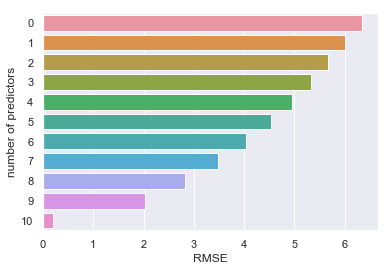

In [4]:
# generate data
n = 10000
p = 10
beta = np.repeat(2, p)
train, test = generate_example_data(n, p, beta, 0.2)

# Search for best predictors with training set
train_X, train_y = train.drop('y', axis=1), train.y
scores, models, vectors = stepwise(train_X ,train_y, forward=True)

# Evaluate best predictors with test set
test_X, test_y = test.drop('y', axis=1), test.y
rmses = compute_rmses(models, vectors, test_X.values, test_y.values)

# plot error vs number of predictors
bar_df = pd.DataFrame({'RMSE' : rmses,'number of predictors' : np.arange(0, len(rmses))})
sns.barplot(y='number of predictors', x='RMSE', data=bar_df, orient='h')

Example 1: **Backward stepwise** - all predictors are equally associated with the outcome

Searching over 56 models


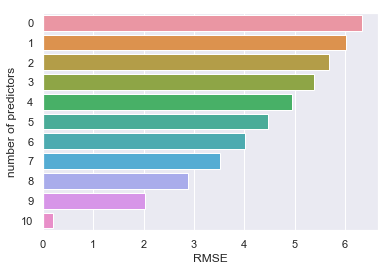

In [5]:
# generate data
n = 10000
p = 10
beta = np.repeat(2, p)
train, test = generate_example_data(n, p, beta, 0.2)

# Search for best predictors with training set
train_X, train_y = train.drop('y', axis=1), train.y
scores, models, vectors = stepwise(train_X ,train_y, forward=False)

# Evaluate best predictors with test set
test_X, test_y = test.drop('y', axis=1), test.y
rmses = compute_rmses(models, vectors, test_X.values, test_y.values, False)

# plot error vs number of predictors
bar_df = pd.DataFrame({'RMSE' : rmses, 'number of predictors' : list(reversed(range(0,len(rmses))))})
sns.barplot(y='number of predictors', x='RMSE', data=bar_df, orient='h')

Example 2: **Forward stepwise** - Half of the predictors are equally associated with the respone, the rest are not associated with the response

Searching over 56 models


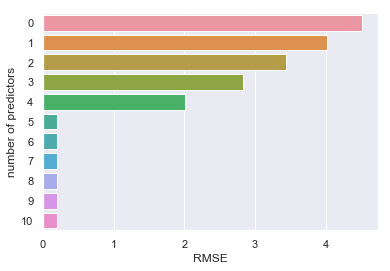

In [6]:
# generate data
n = 10000
p = 10
beta = np.append(np.repeat(0, 5), np.repeat(2, 5))
train, test = generate_example_data(n, p, beta, 0.2)

# Search for best predictors with training set
train_X, train_y = train.drop('y', axis=1), train.y
scores, models, vectors = stepwise(train_X ,train_y, forward=True)

# Evaluate best predictors with test set
test_X, test_y = test.drop('y', axis=1), test.y
rmses = compute_rmses(models, vectors, test_X.values, test_y.values)

# plot error vs number of predictors
bar_df = pd.DataFrame({'RMSE' : rmses,'number of predictors' : np.arange(0, len(rmses))})
sns.barplot(y='number of predictors', x='RMSE', data=bar_df, orient='h')

Example 2: **Backward stepwise** - Half of the predictors are equally associated with the respone, the rest are not associated with the response

Searching over 56 models


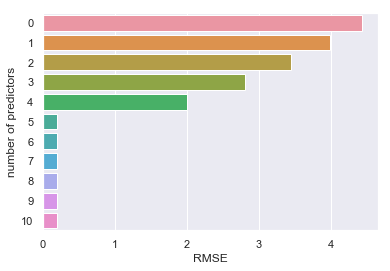

In [7]:
# generate data
n = 10000
p = 10
beta = np.append(np.repeat(0, 5), np.repeat(2, 5))
train, test = generate_example_data(n, p, beta, 0.2)

# Search for best predictors with training set
train_X, train_y = train.drop('y', axis=1), train.y
scores, models, vectors = stepwise(train_X ,train_y, forward=False)

# Evaluate best predictors with test set
test_X, test_y = test.drop('y', axis=1), test.y
rmses = compute_rmses(models, vectors, test_X.values, test_y.values, False)

# plot error vs number of predictors
bar_df = pd.DataFrame({'RMSE' : rmses, 'number of predictors' : list(reversed(range(0,len(rmses))))})
sns.barplot(y='number of predictors', x='RMSE', data=bar_df, orient='h')